# **다중분류 모델링: 와인 품질 분류**

<center><img src = "https://github.com/Jangrae/img/blob/master/wine.jpg?raw=true" width=800/></center>

## **1. 환경준비**

### (1) 라이브러리 불러오기

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (2) 함수 만들기

In [2]:
# 함수 만들기
def dl_history_plot(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss', marker='.')
    plt.plot(history['val_loss'], label='Validation Loss', marker='.')

    plt.title('Learning Curve', size=15, pad=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

### (3) 데이터 준비

In [3]:
# 데이터 준비
path = 'https://raw.githubusercontent.com/Jangrae/csv/master/winequality-white.csv'
data = pd.read_csv(path)
data['quality'] = np.where(data['quality']<5, 5, np.where(data['quality']>7, 7, data['quality']))
data['quality'] = data['quality'] - 5

# Label Encoder를 경험하기 위해 문자열로 변환
data['quality'] = data['quality'].map({0: 'Low', 1: 'Medium', 2: 'High'})
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,Medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,Medium
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,Medium
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,Medium
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,Medium


**데이터 설명**

- fixed acidity: 와인의 휘발되지 않는 산(주로 타르타르산, 숙신산 등) 농도로, 산미와 맛의 균형에 영향을 줌
- volatile acidity: 휘발성 산(주로 아세트산) 농도로, 높은 수치는 불쾌한 식초 맛을 유발할 수 있음
- citric acid: 구연산 함량으로, 적당히 있으면 신선한 맛을 주고, 너무 많으면 거칠게 느껴짐
- residual sugar: 발효 후 남아있는 설탕 함량으로, 와인의 단맛 수준을 결정
- chlorides: 염화물(주로 소금) 함량으로, 너무 높으면 와인의 맛이 짜게 느껴질 수 있음
- free sulfur dioxide: 자유 이산화황 농도(SO₂, 방부 역할)로, 미생물 성장 억제 및 산화 방지에 기여
- total sulfur dioxide: 총 이산화황 함량(자유형 + 결합형)으로, 너무 많으면 향에 영향을 주고, 법적으로도 제한 있음
- density: 와인의 밀도로, 당분과 알코올 함량에 영향을 받음
- pH: 산도(산성 ↔ 알칼리성 정도)로, 일반적으로 2.9~3.9 사이 값
- sulphates: 황산염 농도로, SO₂ 생성에 기여하며, 항산화 및 방부제로 작용
- alcohol: 알코올 도수(%)
- quality: 와인의 품질 점수 (Low, Medium, High)

In [4]:
# 범줏값 확인|
data['quality'].value_counts().sort_index()

quality
High      1060
Low       1640
Medium    2198
Name: count, dtype: int64

## **2. 데이터 전처리**

### (1) 데이터 준비

#### 1) 데이터 분리

In [5]:
# x, y 분리
target = 'quality'
x = data.drop(columns=target)
y = data.loc[:, target]

#### 2) Label Encoding

- LabelEncoder() 함수를 사용하면 임의 순서로 0, 1, 2 정수가 부여됩니다.
- 변환 결과는 배열이 됩니다.

In [6]:
# 선언하기
encoder = LabelEncoder()

# 인코딩
y2 = encoder.fit_transform(y)

# 확인
print(y.values[:10])
print(y2[:10])

['Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium']
[2 2 2 2 2 2 2 2 2 2]


- 의미 있는 순서로 0, 1, 2 정수가 부여되게 하려면 직접 변경하면 됩니다.
- 변환 결과는 y와 동일한 시리즈 형태가 됩니다.

In [7]:
# 직접 변경
y2 = y.map({'Low': 0, 'Medium': 1, 'High': 2})

# 확인
print(y.values[:10])
print(y2.values[:10])

['Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium']
[1 1 1 1 1 1 1 1 1 1]


In [22]:
from tensorflow.keras.utils import to_categorical

y2 = to_categorical(y2, num_classes=3)
print(y2[:5])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


### (2) 데이터 분할

In [8]:
# 학습용, 검증용 분리
x_train, x_val, y_train, y_val = train_test_split(x, y2, test_size=0.2, random_state=1)

### (3) 스케일링

In [9]:
# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## **3. 모델링 1**

### (1) 모델 선언

In [10]:
# 메모리 정리
clear_session()

# 입력 Feature 수
nfeatures = x.shape[1]

# Sequential 모델 선언
model = Sequential([
    Input(shape=(nfeatures,)),
    Dense(3, activation='softmax')
])

# 모델 요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36 (144.00 B)

 Trainable params: 36 (144.00 B)

 Non-trainable params: 0 (0.00 B)

### (2) 모델 학습

In [11]:
# 학습 설정
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy' )

In [12]:
# 모델 학습
hist = model.fit(x_train, y_train, epochs=20, validation_split=0.2, verbose=0).history

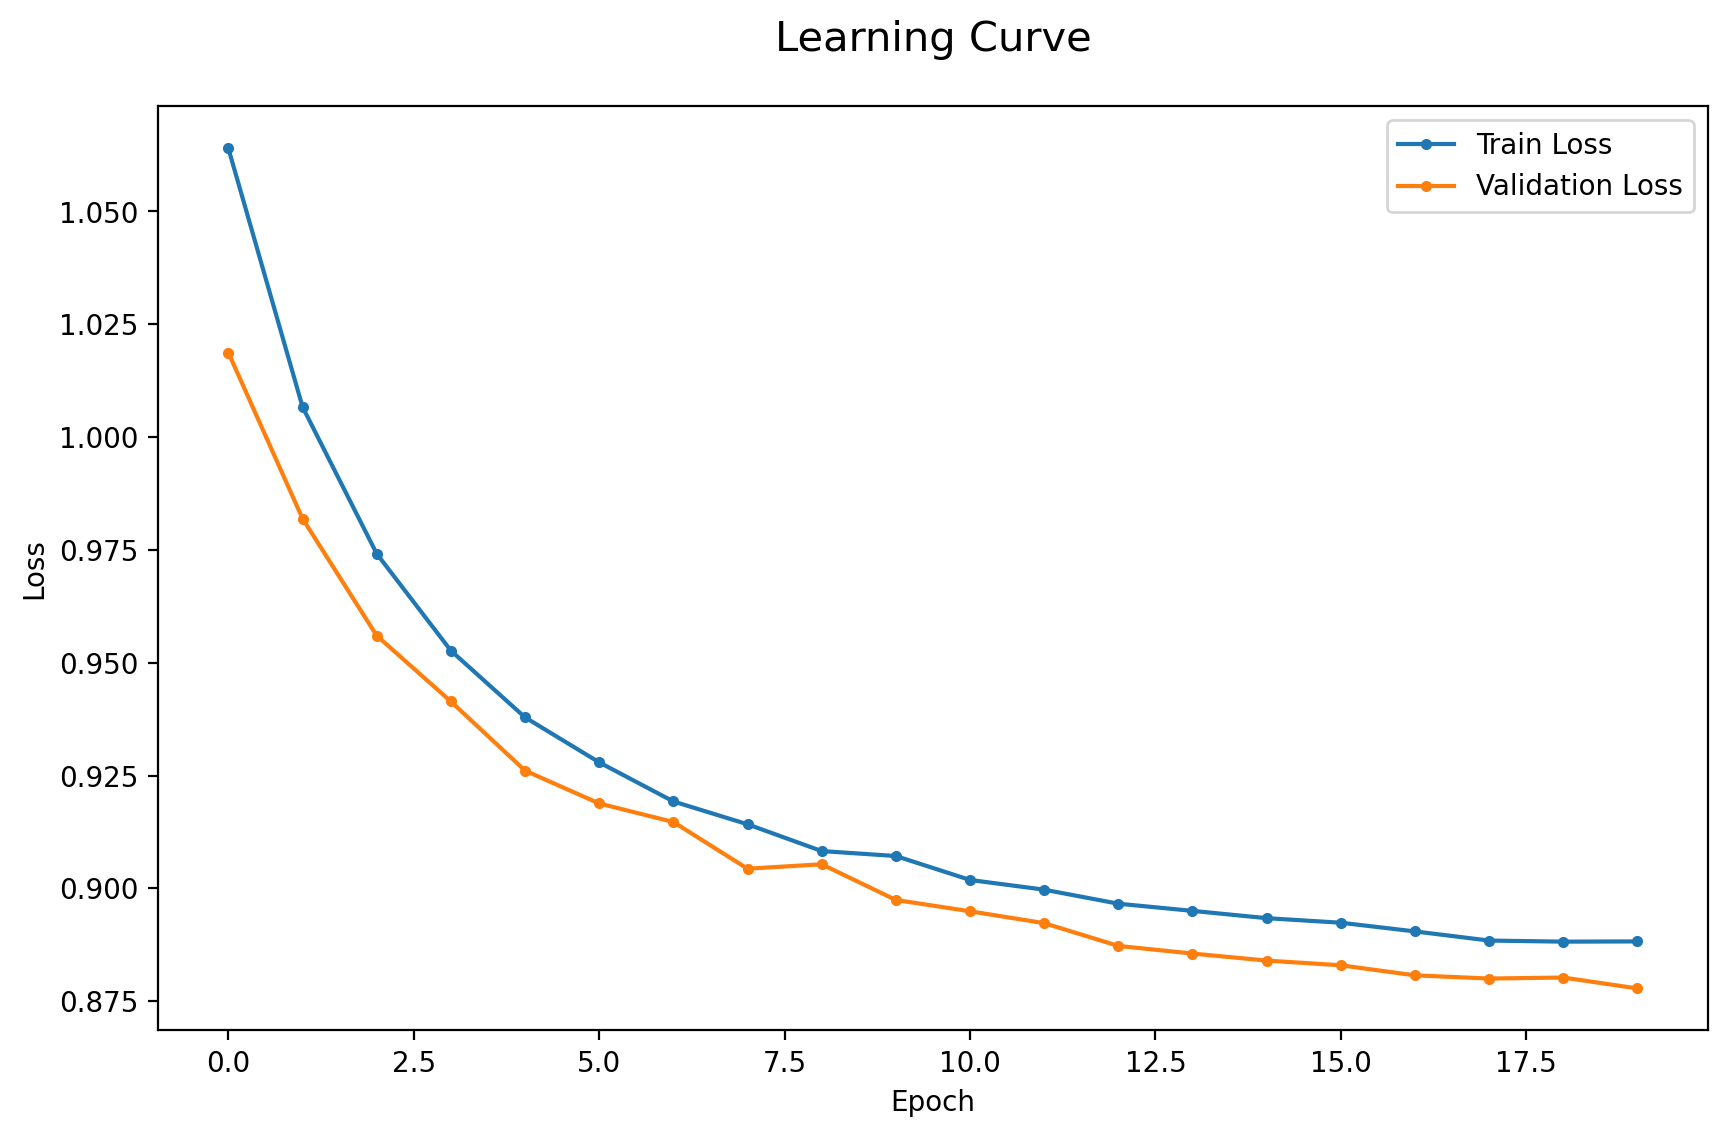

In [13]:
# 학습 곡선
dl_history_plot(hist)

### (3) 예측 및 성능 평가

- 예측 결과는 softmax로 변환된 값 입니다.

In [18]:
# 예측
y_pred = model.predict(x_val)
print(y_pred[:5])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[[0.6604505  0.31041658 0.02913291]
 [0.5139932  0.41841564 0.0675911 ]
 [0.18748313 0.53850603 0.2740108 ]
 [0.5532901  0.3876723  0.05903753]
 [0.07862266 0.4062201  0.5151573 ]]


* 행 별로 가장 큰 값의 인덱스로 변환 합니다.

In [19]:
# 가장 큰 값의 인덱스로 변환
y_pred = np.argmax(y_pred, axis=1)
print(y_pred[:5])

[0 0 1 0 2]


In [21]:
# 성능 평가
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, zero_division=0))

[[167 154   3]
 [ 88 307  40]
 [  8 150  63]]
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       324
           1       0.50      0.71      0.59       435
           2       0.59      0.29      0.39       221

    accuracy                           0.55       980
   macro avg       0.58      0.50      0.51       980
weighted avg       0.57      0.55      0.54       980



## **4. 모델링 2**

- 다음 Summary를 보고 모델을 설계합니다.

| Layer (type) | Output Shape | Param # | 옵션 |
| ---- | ---- | ---- | ---- |
| dense (Dense) | (None, 8) | 40 | node, input_shape, activation = 'relu' |
| dense_1 (Dense) | (None, 3) | 27 | node, activation = 'softmax'  |

### (1) 모델 선언

In [23]:
# 메모리 정리
clear_session()

# 입력 Feature 수
nfeatures = x.shape[1]

# Sequential 모델 선언
model = Sequential([
    Input(shape=(nfeatures,)),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

# 모델 요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123 (492.00 B)

 Trainable params: 123 (492.00 B)

 Non-trainable params: 0 (0.00 B)

### (2) 모델 학습

In [24]:
# 학습 설정
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy' )

In [25]:
# 모델 학습
hist = model.fit(x_train, y_train, epochs=150, validation_split=0.2, verbose=0).history

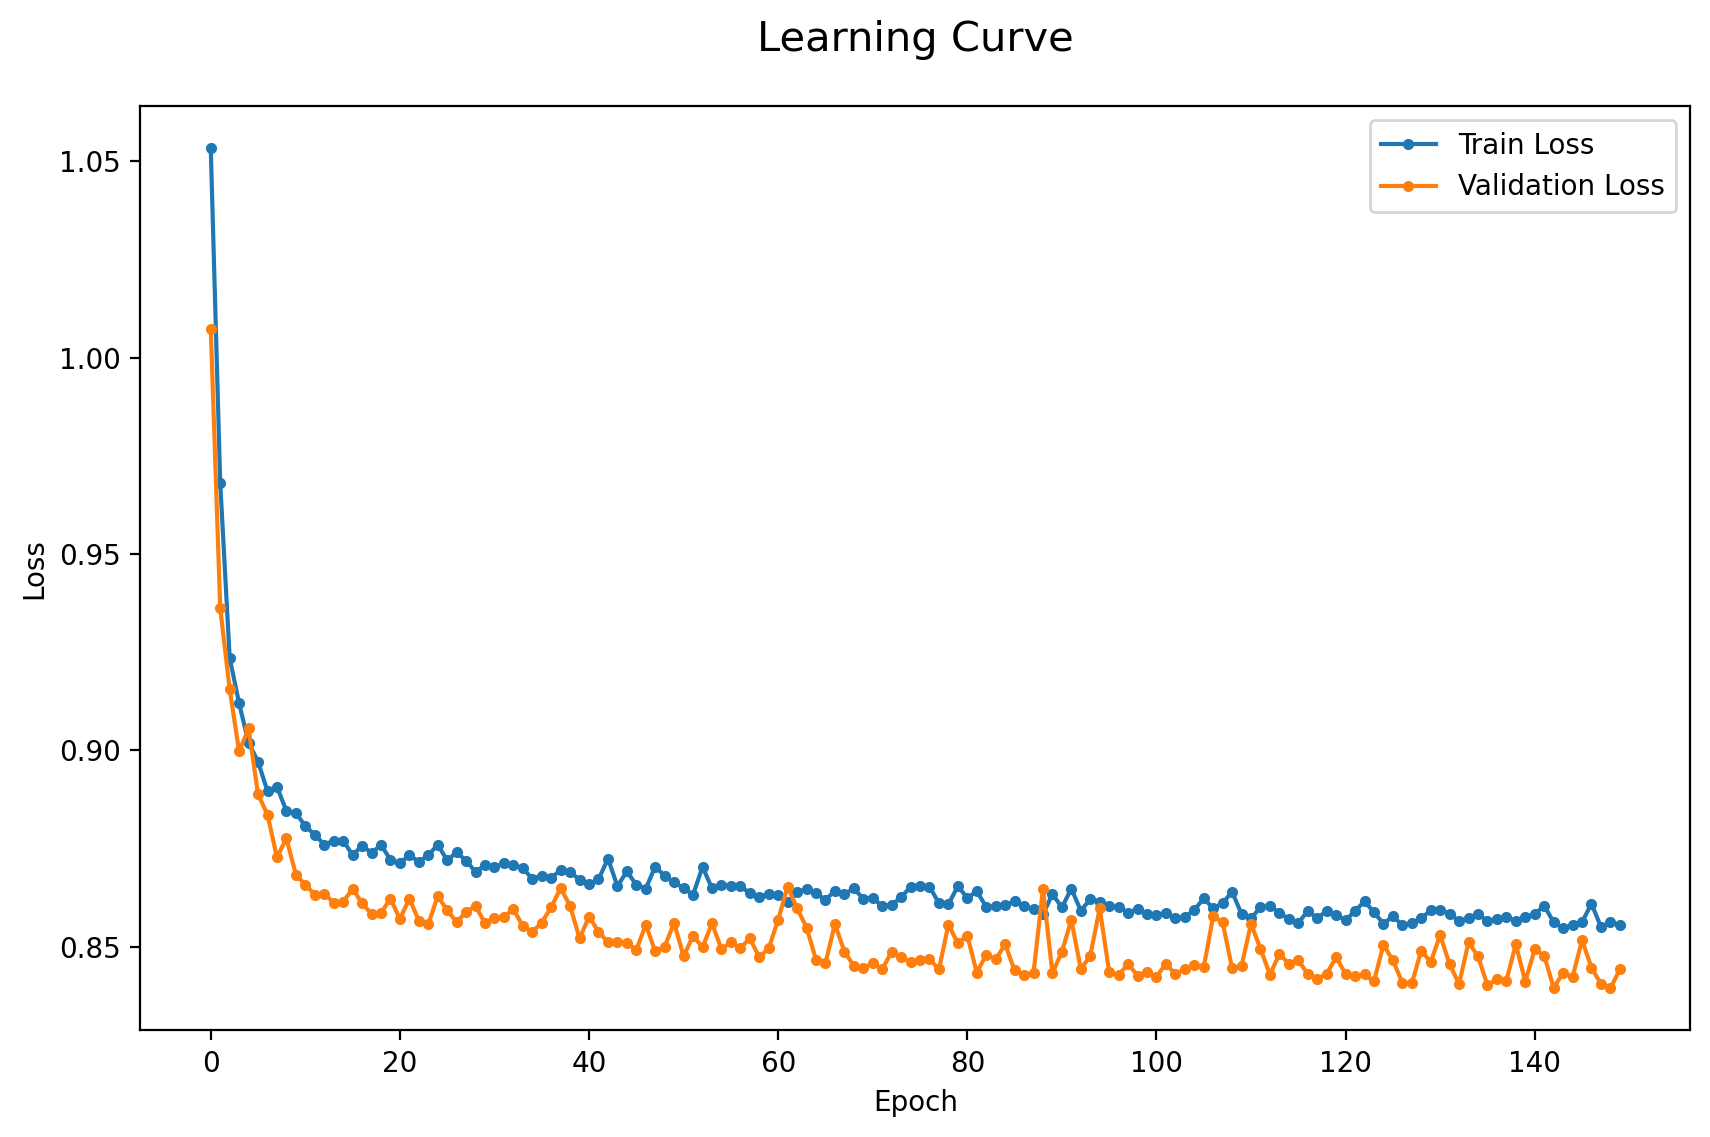

In [26]:
# 학습 곡선
dl_history_plot(hist)

### (3) 예측 및 성능 평가

- 예측 결과는 softmax로 변환된 값 입니다.

In [27]:
# 예측
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [28]:
# 성능 평가
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, zero_division=0))

[[188 125  11]
 [112 249  74]
 [  7 114 100]]
              precision    recall  f1-score   support

           0       0.61      0.58      0.60       324
           1       0.51      0.57      0.54       435
           2       0.54      0.45      0.49       221

    accuracy                           0.55       980
   macro avg       0.55      0.54      0.54       980
weighted avg       0.55      0.55      0.55       980



## **5. 모델링 3**

- 다음의 summary를 보고 모델을 설계하시오.

| Layer (type) | Output Shape | Param # | 옵션 |
| ---- | ---- | ---- | ---- |
| dense (Dense) | (None, 8) | 40 | node, input_shape, activation = 'relu' |
| dense_1 (Dense) | (None, 8) | 72 | node, activation = 'relu'  |
| dense_2 (Dense) | (None, 3) | 27 | node, activation = 'softmax'  |

### (1) 모델 선언

In [29]:
# 메모리 정리
clear_session()

# 입력 Feature 수
nfeature = x_train.shape[1]

# Sequential 모델 선언
model = Sequential([
    Input(shape=(nfeature,)),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

# 모델 요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123 (492.00 B)

 Trainable params: 123 (492.00 B)

 Non-trainable params: 0 (0.00 B)

### (2) 모델 학습

In [30]:
# 학습 설정
model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy' )

In [31]:
# 모델 학습
hist=model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0).history

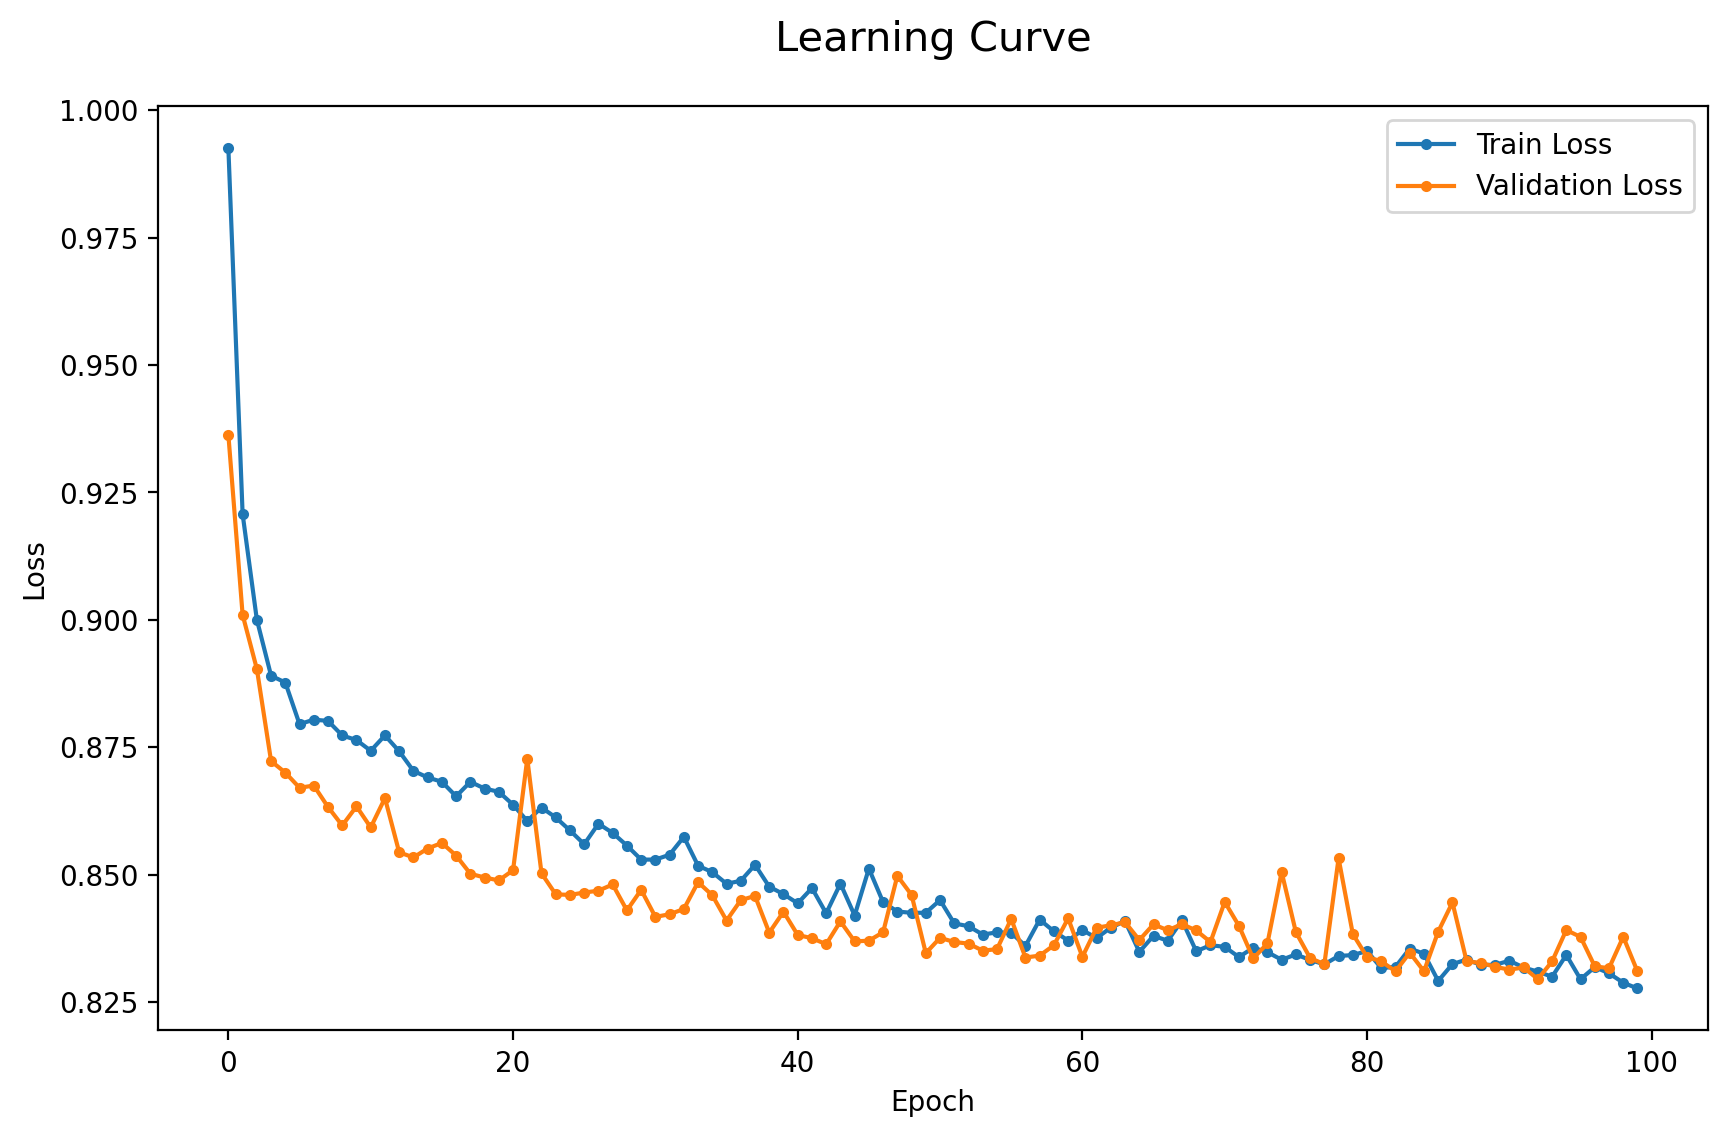

In [32]:
# 학습 곡선
dl_history_plot(hist)

### (3) 예측 및 성능 평가

- 예측 결과는 softmax로 변환된 값 입니다.

In [33]:
# 예측
y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [34]:
# 성능 평가
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred, zero_division=0))

[[169 150   5]
 [ 85 293  57]
 [  3 129  89]]
              precision    recall  f1-score   support

           0       0.66      0.52      0.58       324
           1       0.51      0.67      0.58       435
           2       0.59      0.40      0.48       221

    accuracy                           0.56       980
   macro avg       0.59      0.53      0.55       980
weighted avg       0.58      0.56      0.56       980



## **참고: One-hot Encoding 후 모델링**

### (1) 데이터 전처리

#### 1) One-hot Encoding

- Label Encoding된 결과, 즉 y2에 대해 One-hot Encoding을 수행합니다.

In [35]:
# 함수 불러오기
from keras.utils import to_categorical

# One-hot Encoding
y3 = to_categorical(y2, 3)

# 확인
print(y3[:5])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


#### 2) 데이터 분할

In [36]:
# 학습용, 검증용 분리
x_train, x_val, y_train, y_val = train_test_split(x, y3, test_size=0.2, random_state=1)

#### 3) 스케일링

In [37]:
# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (2) 모델링

#### 1) 모델 선언

In [38]:
# 메모리 정리
clear_session()

# 입력 Feature 수
nfeatures = x.shape[1]

# Sequential 모델 선언
model = Sequential([
    Input(shape=(nfeatures, )),
    Dense(3, activation='softmax')
])

# 모델 요약
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36 (144.00 B)

 Trainable params: 36 (144.00 B)

 Non-trainable params: 0 (0.00 B)

#### 2) 모델 학습

- y를 one-hot encoding 했다면, loss fuction은 **categorical_crossentropy** 입니다.

In [39]:
# 학습 설정
model.compile(optimizer=Adam(learning_rate=0.1), loss='categorical_crossentropy')

In [40]:
# 모델 학습
hist = model.fit(x_train, y_train, epochs=200, validation_split=0.2, verbose=0).history

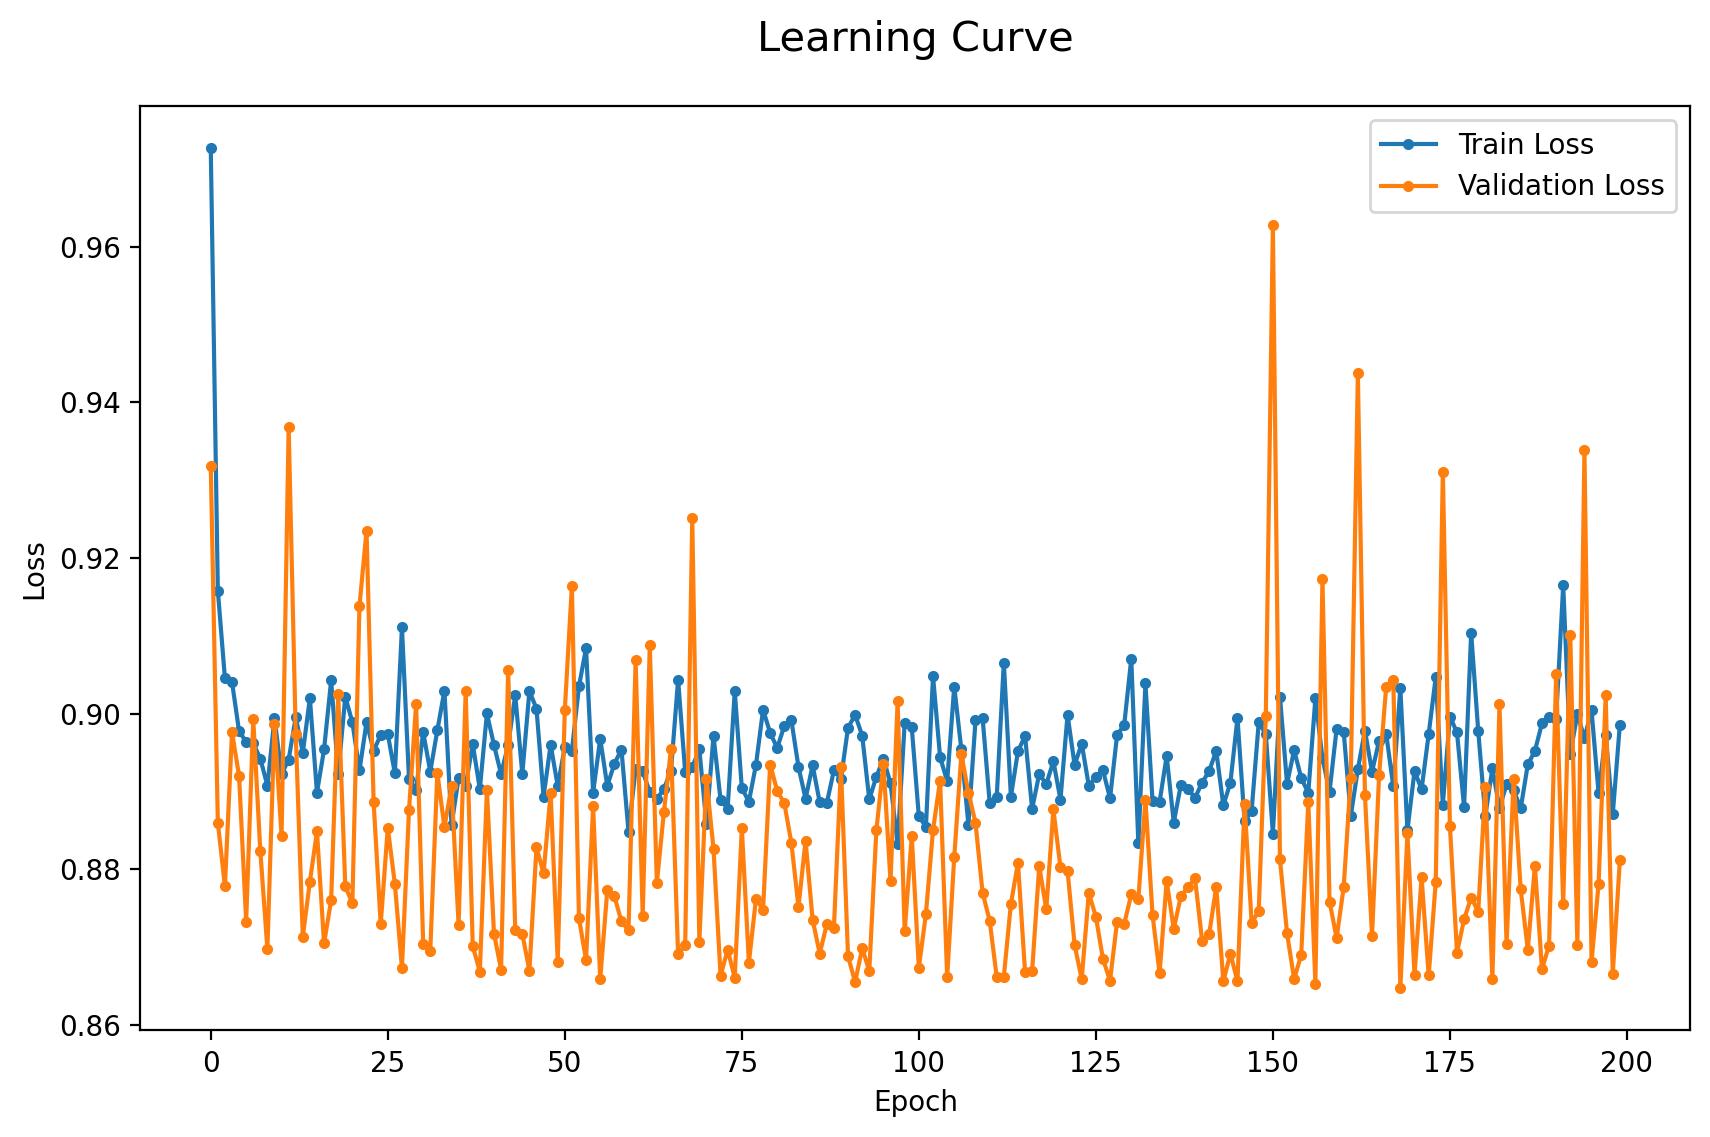

In [41]:
# 학습 곡선
dl_history_plot(hist)

#### 3) 예측 및 성능 평가

- 예측 결과는 softmax로 변환된 값 입니다.

In [42]:
# 예측
pred = model.predict(x_val)
pred = np.argmax(pred, axis=1)
print(pred[:5])

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[0 0 1 0 2]


* 실제값 y_val도 원래 대로 돌려 놓습니다.

In [43]:
# 되돌리기
y_val = y_val.argmax(axis=1)
print(y_val[:5])

[0 1 2 0 2]


In [44]:
# 성능 평가
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[229  84  11]
 [156 193  86]
 [ 30  85 106]]
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       324
           1       0.53      0.44      0.48       435
           2       0.52      0.48      0.50       221

    accuracy                           0.54       980
   macro avg       0.54      0.54      0.53       980
weighted avg       0.54      0.54      0.53       980

